<a href="https://colab.research.google.com/github/PTrillat/Reinforcement-Learning/blob/main/Pendule.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Le simulateur du pendule inversé
Équations de Lagrange + RK4 pour l'intégration numérique

In [ ]:
import numpy as np
import numpy.random as random
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from itertools import count
from collections import namedtuple, deque

class Pendule(object):
  def __init__(self, m, l, g, θ, dθ):
    self.const = (m, l, g)
    self.X = θ
    self.dX = dθ
  
  @staticmethod
  def ddX(const, X, dX, C):
    m, l, g = const
    return (m*l*g*np.sin(X) + C) / (m*l*l)
  
  def Simpson(self, h, C=0.0):
    X0 = self.X
    dX0 = self.dX
    ddX0 = self.ddX(self.const, X0, dX0, C)
    X1 = X0 + h/2*dX0
    dX1 = dX0 + h/2*ddX0
    ddX1 = self.ddX(self.const, X1, dX1, C)
    X2 = X0 + h/2*dX1
    dX2 = dX0 + h/2*ddX1
    ddX2 = self.ddX(self.const, X2, dX2, C)
    X3 = X0 + h*dX2
    dX3 = dX0 + h*dX2
    ddX3 = self.ddX(self.const, X3, dX3, C)
    self.X  += h/6*( dX0 +  2*dX1 +  2*dX2 +  dX3)
    self.dX += h/6*(ddX0 + 2*ddX1 + 2*ddX2 + ddX3)


class Chariot(object):
  def __init__(self, M, m, l, g, x, dx, θ, dθ):
    self.const = (M, m, l, g)
    self.X  = np.array([x, θ])
    self.dX = np.array([dx, dθ])
  
  @staticmethod
  def ddX(const, X, dX, F):
    M, m, l, g = const
    x, θ = X
    dx, dθ = dX
    s, c = np.sin(θ), np.cos(θ)
    a, b, c, d, x, y = l, -m*c*l, -c, M+m, F + m*l*dθ*dθ*s, g*s
    return np.array([a*x + b*y, c*x + d*y]) / (a*d-c*b)

  def Simpson(self, h, F=0.0):
    # f(x, dx) = (dx, ddx(x, dx))
    X0 = self.X
    dX0 = self.dX
    ddX0 = self.ddX(self.const, X0, dX0, F)
    X1 = X0 + h/2*dX0
    dX1 = dX0 + h/2*ddX0
    ddX1 = self.ddX(self.const, X1, dX1, F)
    X2 = X0 + h/2*dX1
    dX2 = dX0 + h/2*ddX1
    ddX2 = self.ddX(self.const, X2, dX2, F)
    X3 = X0 + h*dX2
    dX3 = dX0 + h*dX2
    ddX3 = self.ddX(self.const, X3, dX3, F)
    self.X  += h/6*( dX0 +  2*dX1 +  2*dX2 +  dX3)
    self.dX += h/6*(ddX0 + 2*ddX1 + 2*ddX2 + ddX3)

Animation du pendule et du chariot pour vérifier

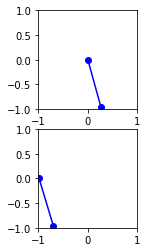

In [ ]:
dt = 0.1
T = 10.0
pendule = Pendule(1.0, 1.0, 9.81, 0.9*np.pi, 0.0)
chariot = Chariot(1.0, 1.0, 1.0, 9.81, -1.0, 0.0, 0.9*np.pi, 0.0)

fig, (axp, axc) = plt.subplots(2,1) # pour le pendule et le chariot
axp.set_xlim(-1,1)
axp.set_ylim(-1,1)
axp.set_aspect('equal', 'box')
linep, = axp.plot([], [], 'bo-')
axc.set_xlim(-1,1)
axc.set_ylim(-1,1)
axc.set_aspect('equal', 'box')
linec, = axc.plot([], [], 'bo-')

def animate(i):
  dθ = pendule.dX
  pendule.Simpson(dt, 10-dθ)
  θ = pendule.X
  linep.set_data([0, np.sin(θ)], [0, np.cos(θ)])
  dx, dθ = chariot.dX
  chariot.Simpson(dt, 1.0-dx)
  x, θ = chariot.X
  linec.set_data([x, x+np.sin(θ)], [0, np.cos(θ)])
  return linep, linec
 
ani = animation.FuncAnimation(fig, animate, frames=int(T/dt), blit=True, interval=int(1000*dt), repeat=False)

Et on lance l'animation

In [ ]:
from matplotlib import rc
rc('animation', html='html5')

ani

# Les réseaux de neurones

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

taille_entree = 2
taille_action = 1
α = 0.001

class Pi(nn.Module):
    def __init__(self, taille_entree, taille_action):
        super(Pi, self).__init__()
        self.taille_entree = taille_entree
        self.taille_action = taille_action
        self.couche1 = nn.Linear(   taille_entree, 10*taille_entree)
        self.couche2 = nn.Linear(10*taille_entree, 10*taille_action)
        self.couche3 = nn.Linear(10*taille_action,    taille_action)

    def forward(self, s):
        temp = F.relu(self.couche1(s))
        temp = F.relu(self.couche1(temp))
        temp = Categorical(F.softmax(self.couche3(temps), dim=-1))
        return temp


class Qu(nn.Module):
    def __init__(self, taille_entree, taille_action):
        super(Qu, self).__init__()
        self.taille_entree = taille_entree
        self.taille_action = taille_action
        self.linear1 = nn.Linear(self.state_size, 128)
        self.linear2 = nn.Linear(128, 256)
        self.linear3 = nn.Linear(256, 1)

    def forward(self, state):
        output = F.relu(self.linear1(state))
        output = F.relu(self.linear2(output))
        value = self.linear3(output)
        return value

In [ ]:
pi = Pi(2,1)

TypeError: ignored